## 이 파일의 목적

svm을 제외한 모델에서의 결과를 살펴보고 본다. 여기선 oversampling(smooth)와 minmax가 사용되었다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install catboost
!pip install lightgbm
!pip install ngboost
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.2/349.2 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.2/94.2 kB 6.4 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=b1e2788bea8e2e5f8b7b723e5bf8a3e627bc424184202d53d8224929dac09d8e
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 9.0 MB/s eta 0:00:00


In [ ]:
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Essentials
import numpy as np
import pandas as pd
import random
import time
import gc
import os
from datetime import datetime

# Plots
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
import seaborn as sns
# matplotlib 의 기본 scheme 말고
# seaborn scheme 을 세팅하여, 일일이 graph의 font size 지정할 필요 없이
# seaborn 의 font_scale 을 사용하는 것을 추천드립니다.
plt.style.use('seaborn')
sns.set(font_scale=2.5)
from matplotlib.pylab import rcParams
##set up the parameters
rcParams['figure.figsize'] = 80,60

# Models
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from ngboost import NGBClassifier, NGBRegressor
from lightgbm.plotting import plot_importance
import lightgbm
import xgboost as xgb
import catboost
from xgboost import plot_tree

# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax


# Misc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

import shap

pd.set_option('display.max_columns', None)

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000

<Figure size 1600x800 with 0 Axes>

In [ ]:
# 이제 마지막 데이터셋! 더이상 바뀔 일 없음
path = '/content/drive/MyDrive/Colab Notebooks/model/4.27_lendingclub_individual_dataset.csv'
path2 = '/content/drive/MyDrive/Colab Notebooks/model/4.28_lendingclub_individual_dataset(test).csv'
df = pd.read_csv(path)
df2 = pd.read_csv(path2)
df

,emp_length_int,installment,int_rate,loan_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,pub_rec,pub_rec_bankruptcies,chargeoff_within_12_mths,collections_12_mths_ex_med,inq_last_6mths,mort_acc,num_rev_accts,open_acc,open_acc_6m,open_act_il,revol_bal,revol_util,loan_status,total_pymnt,funded_amnt_inv,earliest_cr_line_year,earliest_cr_line_month,issue_d_year,issue_d_month,grade_numeric,fico_range_mean,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,term_ 60 months,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,verification_status_Source Verified,verification_status_Verified
0,2,822.95,14.47,35000.0,30.0,154.0,0.0,0.0,0.0,0.0,2.0,0.0,5.0,6.0,1.0,1.0,24640.0,0.354,Current,16430.860000,35000.0,2002,12,2018,9,5,717.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,10,680.82,24.99,23200.0,126.0,277.0,0.0,0.0,0.0,0.0,1.0,2.0,22.0,24.0,1.0,10.0,16909.0,0.559,Charged Off,8599.680000,23200.0,1993,5,2016,7,3,672.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,10,145.06,9.93,4500.0,127.0,265.0,0.0,0.0,0.0,1.0,1.0,0.0,27.0,22.0,2.0,0.0,6435.0,0.121,Current,4204.260000,4500.0,1995,11,2017,12,6,677.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,494.55,7.07,16000.0,134.0,400.0,0.0,0.0,0.0,0.0,0.0,3.0,18.0,18.0,1.0,2.0,3881.0,0.055,Charged Off,11804.280000,16000.0,1984,5,2017,10,7,822.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,5,146.10,10.42,4500.0,226.0,130.0,2.0,2.0,0.0,0.0,0.0,1.0,6.0,7.0,1.0,2.0,6824.0,0.494,Fully Paid,5134.174383,4500.0,1998,7,2017,5,6,702.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1535624,7,133.78,19.99,3600.0,151.0,36.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,8.0,1.0,1.0,9711.0,0.908,Charged Off,469.070000,3600.0,2001,8,2014,3,3,667.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1535625,4,583.89,6.68,19000.0,125.0,216.0,0.0,0.0,0.0,0.0,0.0,5.0,16.0,15.0,1.0,4.0,11421.0,0.414,Fully Paid,20620.112719,18875.0,1997,3,2015,4,7,737.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1535626,9,329.65,14.33,9600.0,25.0,99.0,0.0,0.0,0

In [ ]:
# train 세트
not_deliq = ['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid']

loan_stat = df['loan_status']
target = []
for stat in loan_stat:
    # 연체 하지 않은 경우를 0
    if stat in not_deliq:
        target.append(0)
    # 연체한 경우를 1
    else:
        target.append(1)
print(len(target))
print(len(df))

df['target'] = target

# test 세트
loan_stat2 = df2['loan_status']
target2 = []
for stat in loan_stat2:
    # 연체 하지 않은 경우를 0
    if stat in not_deliq:
        target2.append(0)
    # 연체한 경우를 1
    else:
        target2.append(1)
print(len(target2))
print(len(df2))

df2['target'] = target2

1535629
1535629
1023521
1023521


In [ ]:
# current와 issued 를 제거
df = df[df['loan_status']!= 'Current']
df = df[df['loan_status']!= 'Issued']

df2 = df2[df2['loan_status']!= 'Current']
df2 = df2[df2['loan_status']!= 'Issued']

In [ ]:
df.drop(columns = 'loan_status', inplace = True)
df2.drop(columns = 'loan_status', inplace = True)

In [ ]:
column_types = df.dtypes

# float와 int 나누기
float_columns = []
int_columns = []
for column_name, dtype in column_types.items():
    if dtype == 'float':
        float_columns.append(column_name)
    elif dtype == 'int':
        int_columns.append(column_name)


# 데이터 유형에 따라 변환
df[float_columns] = df[float_columns].astype(np.float32)
df[int_columns] = df[int_columns].astype(np.int16)

df2[float_columns] = df2[float_columns].astype(np.float32)
df2[int_columns] = df2[int_columns].astype(np.int16)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1070411 entries, 1 to 1535627
Data columns (total 98 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   emp_length_int                       1070411 non-null  int16  
 1   installment                          1070411 non-null  float32
 2   int_rate                             1070411 non-null  float32
 3   loan_amnt                            1070411 non-null  float32
 4   mo_sin_old_il_acct                   1070411 non-null  float32
 5   mo_sin_old_rev_tl_op                 1070411 non-null  float32
 6   pub_rec                              1070411 non-null  float32
 7   pub_rec_bankruptcies                 1070411 non-null  float32
 8   chargeoff_within_12_mths             1070411 non-null  float32
 9   collections_12_mths_ex_med           1070411 non-null  float32
 10  inq_last_6mths                       1070411 non-null  float32
 11  mor

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 713816 entries, 0 to 1023519
Data columns (total 98 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   emp_length_int                       713816 non-null  int16  
 1   installment                          713816 non-null  float32
 2   int_rate                             713816 non-null  float32
 3   loan_amnt                            713816 non-null  float32
 4   mo_sin_old_il_acct                   713816 non-null  float32
 5   mo_sin_old_rev_tl_op                 713816 non-null  float32
 6   pub_rec                              713816 non-null  float32
 7   pub_rec_bankruptcies                 713816 non-null  float32
 8   chargeoff_within_12_mths             713816 non-null  float32
 9   collections_12_mths_ex_med           713816 non-null  float32
 10  inq_last_6mths                       713816 non-null  float32
 11  mort_acc         

In [ ]:
# train에서 수익률을 확인하기위한 earing set도 20% 구분해서 저장
earning_test = df.sample(frac=0.2, random_state=42)

In [ ]:
# A, B등급은 우선 제외하고 학습시켜야함
#train
df_nonAB = df[(df['grade_numeric'] < 6)]

In [ ]:
# X와 y를 나누기 위해 list 생성
x_data = list(df.columns)
x_data.remove('target')
# 이 밑에는 사후변수!
x_data.remove('total_pymnt')
x_data.remove('funded_amnt_inv')
# 사후변수및 계산을 필요한 변수는 원본셋이 있으므로 패스

In [ ]:
x_data

['emp_length_int',
 'installment',
 'int_rate',
 'loan_amnt',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'pub_rec',
 'pub_rec_bankruptcies',
 'chargeoff_within_12_mths',
 'collections_12_mths_ex_med',
 'inq_last_6mths',
 'mort_acc',
 'num_rev_accts',
 'open_acc',
 'open_acc_6m',
 'open_act_il',
 'revol_bal',
 'revol_util',
 'earliest_cr_line_year',
 'earliest_cr_line_month',
 'issue_d_year',
 'issue_d_month',
 'grade_numeric',
 'fico_range_mean',
 'home_ownership_MORTGAGE',
 'home_ownership_NONE',
 'home_ownership_OTHER',
 'home_ownership_OWN',
 'home_ownership_RENT',
 'purpose_credit_card',
 'purpose_debt_consolidation',
 'purpose_educational',
 'purpose_home_improvement',
 'purpose_house',
 'purpose_major_purchase',
 'purpose_medical',
 'purpose_moving',
 'purpose_other',
 'purpose_renewable_energy',
 'purpose_small_business',
 'purpose_vacation',
 'purpose_wedding',
 'term_ 60 months',
 'addr_state_AL',
 'addr_state_AR',
 'addr_state_AZ',
 'addr_state_CA',
 'addr_state_CO',
 '

## Standard scaler 적용

In [ ]:
processing = ['emp_length_int',
 'installment',
 'int_rate',
 'loan_amnt',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'pub_rec',
 'pub_rec_bankruptcies',
 'chargeoff_within_12_mths',
 'collections_12_mths_ex_med',
 'inq_last_6mths',
 'mort_acc',
 'num_rev_accts',
 'open_acc',
 'open_acc_6m',
 'open_act_il',
 'revol_bal',
 'revol_util']


In [ ]:
# standard로 scale
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_nonAB[processing])


# 새로운 DF에 스케일된 데이터를 저장
df_nonAB[processing] = scaled_data

In [ ]:
# scaler2 = StandardScaler()
# scaled_data2 = scaler2.fit_transform(df2[processing])
# df2[processing] = scaled_data2

In [ ]:
# 우선 랜덤하게 data_split하고 돌려봄 0.8:0.2
df_train, df_test = train_test_split(df_nonAB, test_size = .2, train_size = 0.8, random_state = 42)
df_train, df_validation = train_test_split(df_train, test_size = .25, train_size = 0.75, random_state = 42)

In [ ]:
X_train = df_train[x_data]
y_train = df_train['target']

X_test = df_validation[x_data]
y_test = df_validation['target']
# Target

In [ ]:
# train셋을 oversampling
from imblearn.over_sampling import ADASYN
smt = ADASYN()
X_train, y_train = smt.fit_resample(df_train[x_data], df_train['target'])

In [ ]:
df_train.describe()

,emp_length_int,installment,int_rate,loan_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,pub_rec,pub_rec_bankruptcies,chargeoff_within_12_mths,collections_12_mths_ex_med,inq_last_6mths,mort_acc,num_rev_accts,open_acc,open_acc_6m,open_act_il,revol_bal,revol_util,total_pymnt,funded_amnt_inv,earliest_cr_line_year,earliest_cr_line_month,issue_d_year,issue_d_month,grade_numeric,fico_range_mean,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,term_ 60 months,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,verification_status_Source Verified,verification_status_Verified,target
count,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.00000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.00000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000
mean,0.000972,0.000911,0.002371,0.000208,0.001240,0.000101,-0.001432,-0.000698,0.000005,0.000231,0.001076,0.000332,0.000315,-0.000685,-0.000704,0.000453,0.001648,0.002472,15663.248047,15112.442383,1999.885108,6.744193,2015.440671,6.516524,4.313077,687.782166,0.455845,0.000033,0.00012,0.112188,0.431261,0.167407,0.612397,0.000213,0.060217,0.007299,0.020995,0.013624,0.009047,0.07376,0.000895,0.015370,0.008233,0.001367,0.381809,0.012931,0.007683,0.023566,0.140242,0.020752,0.014922,0.002250,0.002908,0.073135,0.032770,0.005376,0.000015,0.001535,0.037801,0.016778,0.008065,0.009849,0.011534,0.021278,0.024146,0.001670,0.026660,0.017349,0.015967,0.005836,0.002745,0.028775,0.001424,0.003211,0.004611,0.035788,0.005554,0.015352,0.084342,0.032694,0.009323,0.011603,0.034734,0.004403,0.012297,0.001967,0.016024,0.080029,0.007188,0.028138,0.002006,0.021665,0.012702,0.003731,0.002112,0.409607,0.359738,0.275829
std,1.000247,1.000523,1.001635,0.999789,0.999059,0.999408,0.996917,1.000831,0.988336,1.005713,1.001932,1.000353,1.000081,0.998608,0.998247,1.002610,0.997581,0.999075,11509.639648,914

In [ ]:
def show_time(diff):
   m, s = divmod(diff, 60)
   h, m = divmod(m, 60)
   s,m,h = int(round(s, 0)), int(round(m, 0)), int(round(h, 0))
   print("Execution Time: " + "{0:02d}:{1:02d}:{2:02d}".format(h, m, s))

# Takes in a classifier, calculates the training + prediction times and accuracy score, returns a model
def Train(clf, X, y, X_predict, y_predict, type='classification'):
    # Train
    start = time.time()
    model = clf.fit(X,y)
    end = time.time()
    print('Training time: ')
    show_time(end - start)
    training_times.append(end - start)

    # Predict
    start = time.time()
    if(type=='classification'):
        scores.append(accuracy_score(y_predict, model.predict(X_predict)))
    else:
        scores.append(mean_squared_error(y_test, model.predict(X_test)))
    end = time.time()
    prediction_times.append(end - start)
    print('\nPrediction time: ')
    show_time(end - start)
    return model


# Takes in model scores and plots them on a bar graph
def plot_metric(model_scores, score='Accuracy'):
    # Set figure size
    rcParams['figure.figsize'] = 20,15
    plt.bar(model_scores['Model'], height=model_scores[score])
    xlocs, xlabs = plt.xticks()
    xlocs=[i for i in range(0,17)]
    xlabs=[i for i in range(0,17)]
    if(score != 'Prediction Times'):
        for i, v in enumerate(model_scores[score]):
            plt.text(xlocs[i] - 0.25, v + 0.01, str(v))
    plt.xlabel('Model')
    plt.ylabel(score)
    plt.xticks(rotation=45)
    plt.show()

# Takes in training data and a model, and plots a bar graph of the model's feature importances
def feature_importances(df, model, model_name, max_num_features=10):
    feature_importances = pd.DataFrame(columns = ['feature', 'importance'])
    feature_importances['feature'] = df.columns
    feature_importances['importance'] = model.feature_importances_
    feature_importances.sort_values(by='importance', ascending=False, inplace=True)
    feature_importances = feature_importances[:max_num_features]
    print(feature_importances)
    plt.figure(figsize=(12, 6));
    sns.barplot(x="importance", y="feature", data=feature_importances);
    plt.title(model_name+' features importance:');

# Takes in training data and a model, and plots a bar graph of SHAP values
def shap_values(df, model, model_name):
    shap_values = shap.TreeExplainer(model).shap_values(df)
    shap_values[:5]
    shap.summary_plot(shap_values, df.iloc[:1000,:])

In [ ]:
prediction_times = []
training_times = []
scores = []

decision_tree = Train(DecisionTreeClassifier(max_depth=5), X_train, y_train, X_test, y_test) # 결정트리
random_forest= Train(RandomForestClassifier(n_estimators=50,max_depth=5), X_train, y_train, X_test, y_test) # 랜덤 포레스트. Essemble 중 bagging에 대표적인 모델
extra_trees = Train(ExtraTreesClassifier(n_estimators=50,max_depth=5), X_train, y_train, X_test, y_test) # 랜덤 포레스트와 유사하지만, bagging은 아니다. 속도도 빠르고 bias도 varinace도 줄일 수 있다고 하지만... 최고라고 하기엔 흠?
xgboost = Train(XGBClassifier(n_estimators=100, max_depth=5), X_train, y_train, X_test, y_test)
lgb = Train(LGBMClassifier(n_estimators=100, max_depth=5, num_leaves = 70), X_train, y_train, X_test, y_test)
cat = Train(CatBoostClassifier(n_estimators=50, verbose=False, max_depth=5), X_train, y_train, X_test, y_test)
# xgboost = Train(XGBClassifier(max_depth= 10, min_child_weight= 6, learning_rate = 0.1, n_estimators= 100, penalty= 'ridge', objective = 'binary:logistic', eval_metric = 'auc'), X_train, y_train, X_test, y_test)
# lgb = Train(LGBMClassifier(n_estimators=150, max_depth=20, num_leaves=150,learning_rate = 0.1, objective = 'binary', verbose=1), X_train, y_train, X_test, y_test)
# cat = Train(CatBoostClassifier(l2_leaf_reg= 5, n_estimators=200, learning_rate = 0.1, verbose=1, depth=6, loss_function='Logloss'), X_train, y_train, X_test, y_test)
ngb = Train(NGBClassifier(n_estimators=50, verbose=1, natural_gradient=3), X_train, y_train, X_test, y_test)

Training time: 
Execution Time: 00:00:05

Prediction time: 
Execution Time: 00:00:00
Training time: 
Execution Time: 00:00:18

Prediction time: 
Execution Time: 00:00:00
Training time: 
Execution Time: 00:00:08

Prediction time: 
Execution Time: 00:00:00
Training time: 
Execution Time: 00:00:02

Prediction time: 
Execution Time: 00:00:00
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 230385, number of negative: 241099
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020666 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4513
[LightGBM] [Info] Number of data points in the train set: 471484, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.488638 -> initscore=-0.045456
[LightGBM] [Info] Start training from score -0.045456
[LightGBM] [Warning

특이도(Specificity): 0.682666600345698
민감도(Sensitivity) 또는 재현율(Recall): 0.43691099476439793
정확도(Accuracy): 0.614992295700911
정밀도(Precision): 0.343495150626431


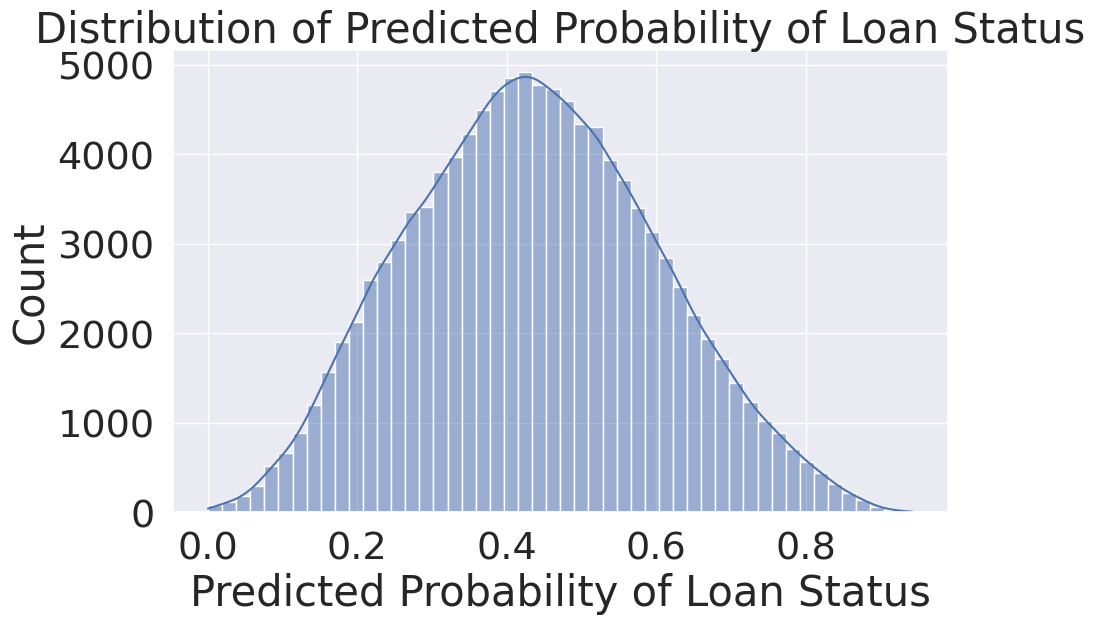

              precision    recall  f1-score   support

           0       0.76      0.68      0.72     80417
           1       0.34      0.44      0.38     30560

    accuracy                           0.61    110977
   macro avg       0.55      0.56      0.55    110977
weighted avg       0.65      0.61      0.63    110977



In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score


# 독립 변수와 종속 변수 분리
# X = df.drop('target', axis=1)  # 독립 변수
# y = df['target']  # 종속 변수

# # 데이터 정규화
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # 훈련 데이터와 테스트 데이터 분리
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# # 오버샘플링 적용
# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 다중 회귀 모델 훈련
model = LogisticRegression()
model.fit(X_train, y_train)

# 테스트 데이터로 예측
y_pred = model.predict(X_test)

# 특이도(Specificity), 민감도(재현율), 정확도, 정밀도 계산
conf_matrix = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = conf_matrix.ravel()
specificity = TN / (TN + FP)
recall = sensitivity = TP / (TP + FN)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print("특이도(Specificity):", specificity)
print("민감도(Sensitivity) 또는 재현율(Recall):", recall)
print("정확도(Accuracy):", accuracy)
print("정밀도(Precision):", precision)

# 예측 결과의 분포 시각화
y_pred_proba = model.predict_proba(X_test)[:, 1]
plt.figure(figsize=(10, 6))
sns.histplot(y_pred_proba, bins=50, kde=True)
plt.xlabel('Predicted Probability of Loan Status')
plt.ylabel('Count')
plt.title('Distribution of Predicted Probability of Loan Status')
plt.show()

from sklearn.metrics import classification_report

print(classification_report(y_test, model.predict(X_test)))

In [ ]:
models = [
    ('DecisionTree', decision_tree),
    ('RandomForest', random_forest),
    ('ExtraTrees', extra_trees),
    ('XGBoost', xgboost),
    ('LightGBM', lgb),
    ('CatBoost', cat),
    ('NgBoost', ngb),
    ('Logistic', model)
]

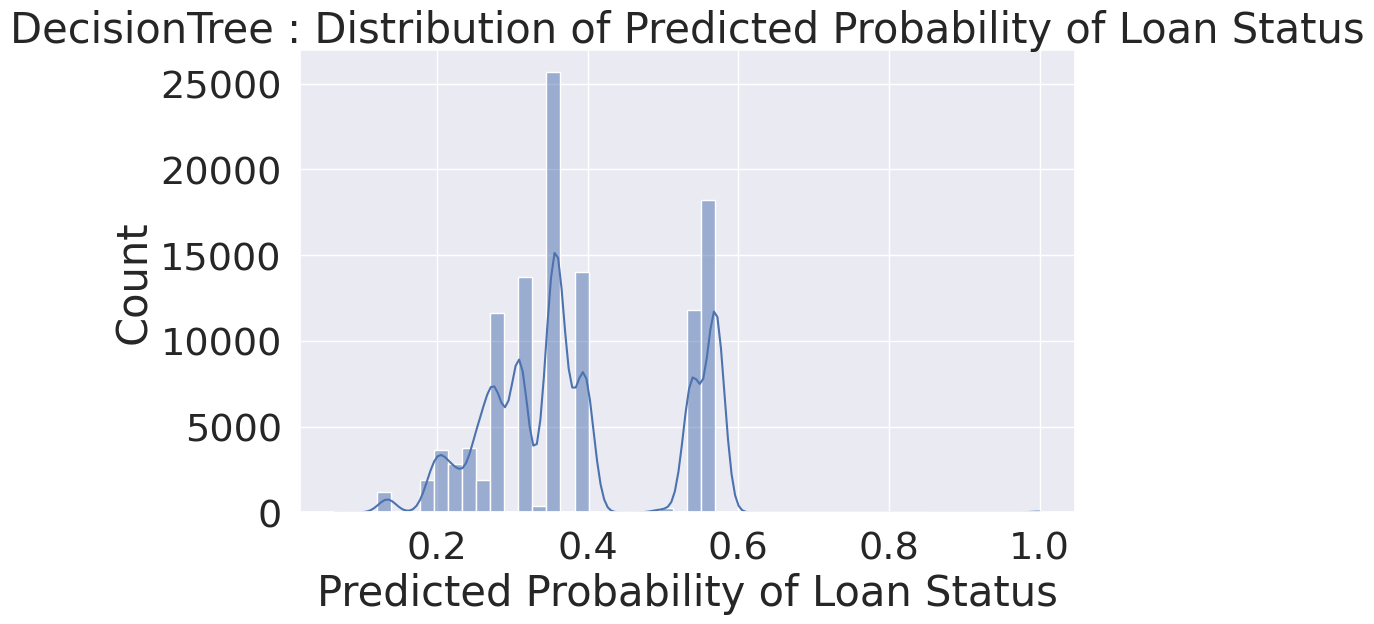

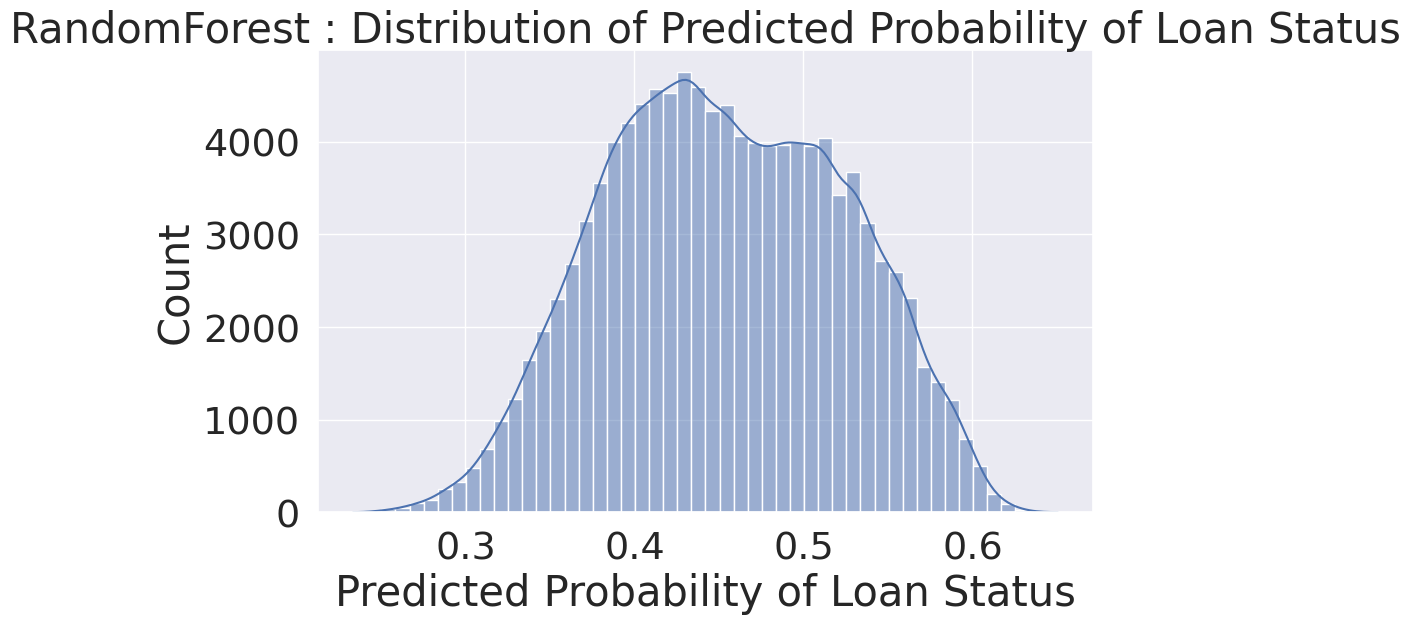

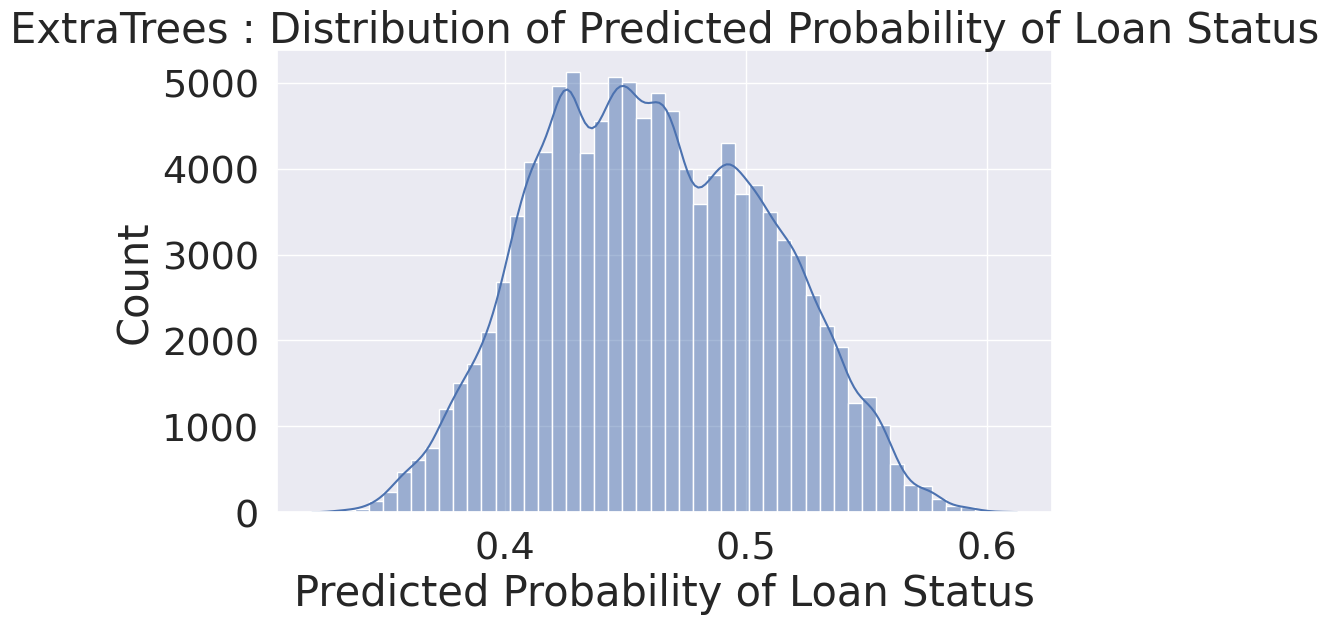

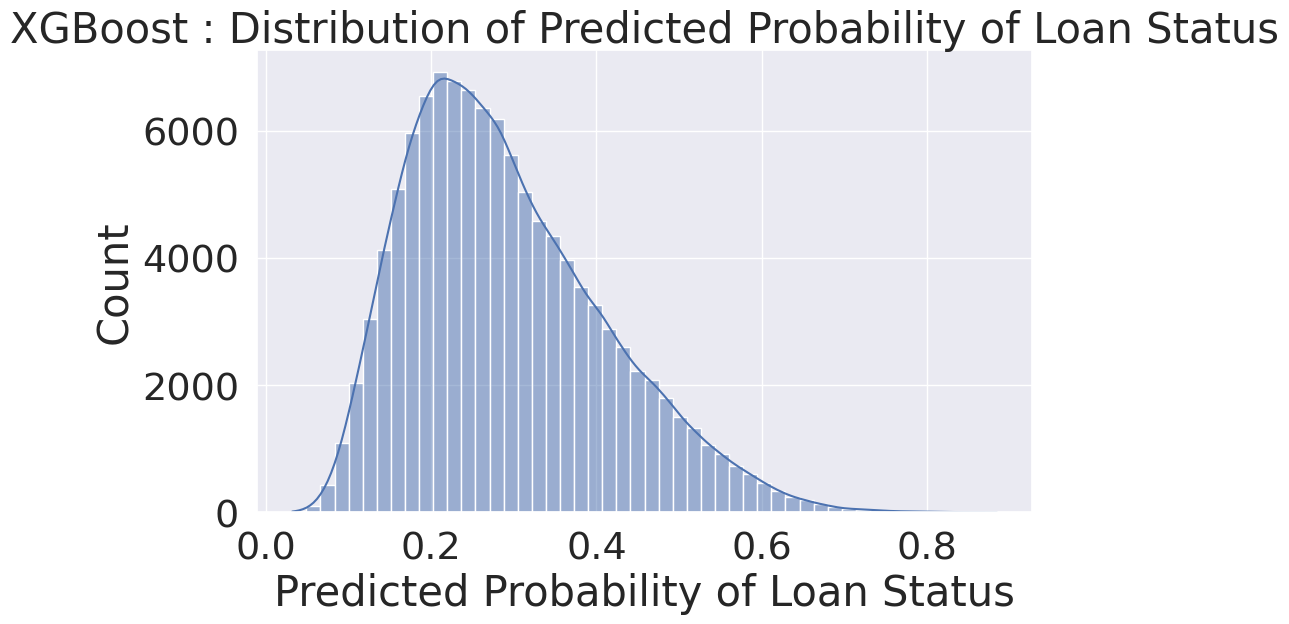

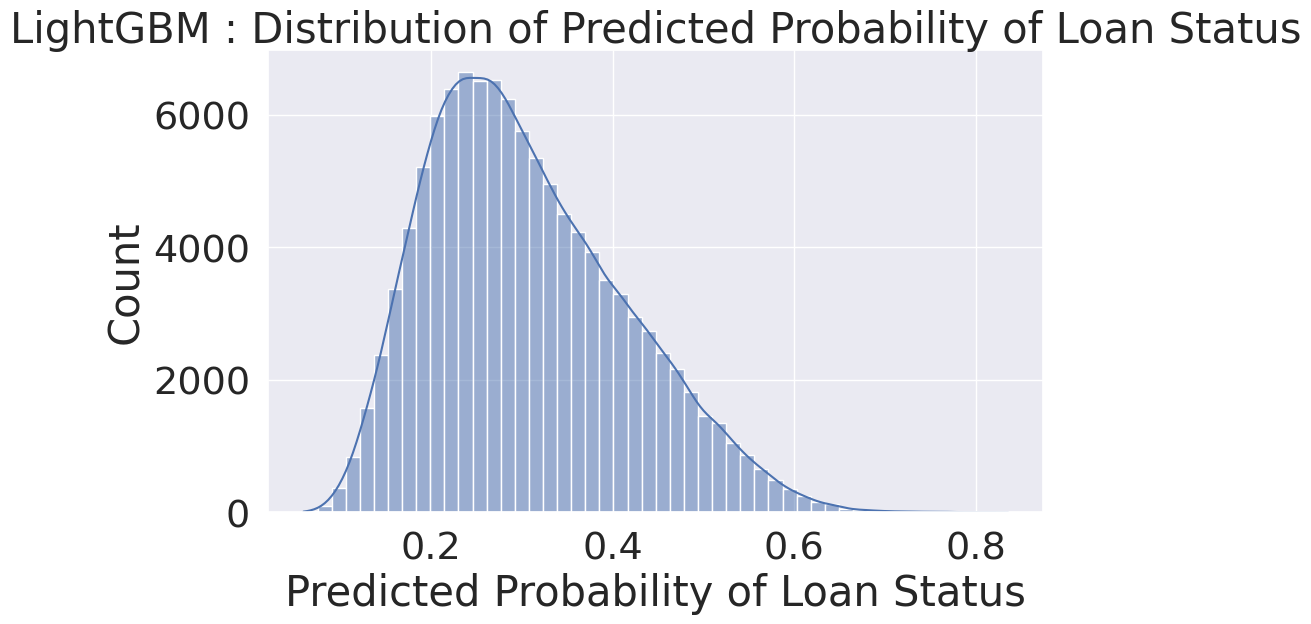

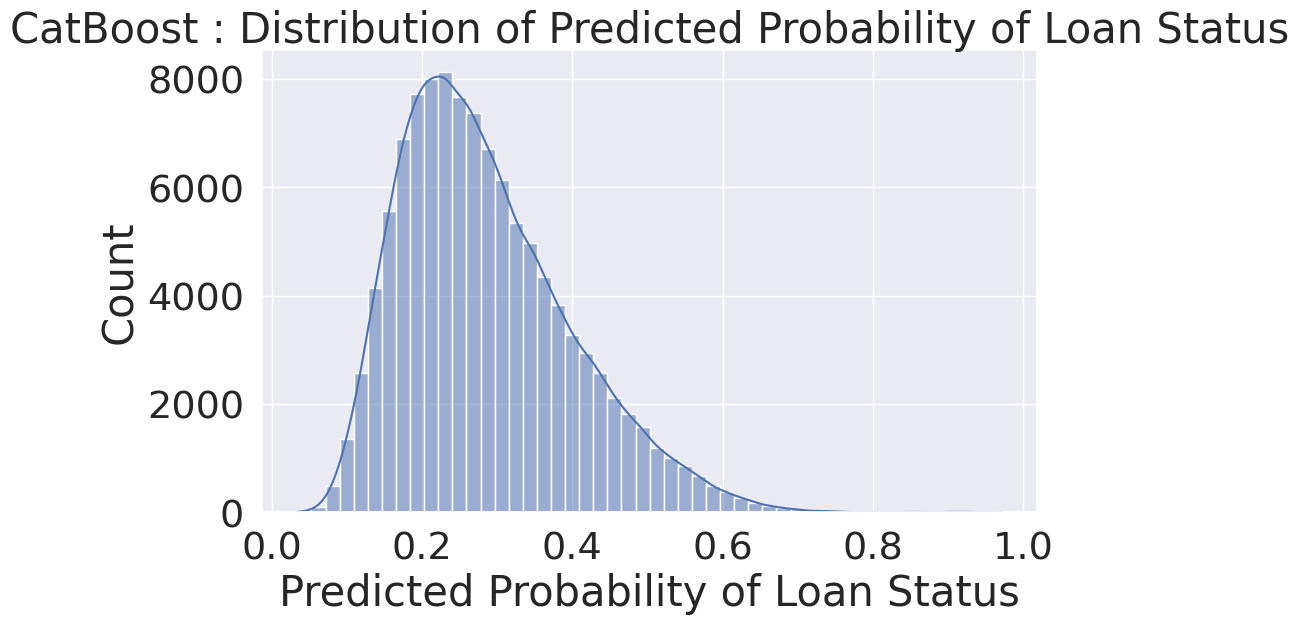

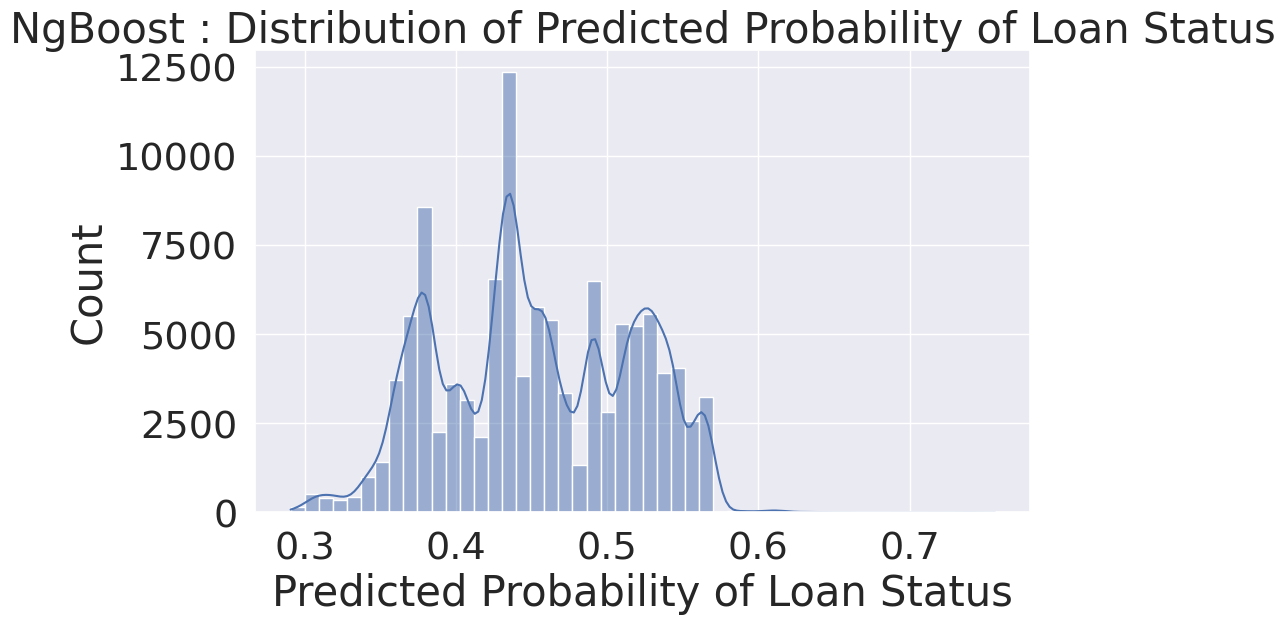

In [ ]:
# 예측 결과의 분포 시각화 (logsitc 제외)
for name, model in models[:-1]:
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    plt.figure(figsize=(10, 6))
    sns.histplot(y_pred_proba, bins=50, kde=True)
    plt.xlabel('Predicted Probability of Loan Status')
    plt.ylabel('Count')
    plt.title(f'{name} : Distribution of Predicted Probability of Loan Status')
    plt.show()

In [ ]:
# score에 있는 점수를 소수점 5째자리까지 반올림
scores.append(accuracy)
for i in range(len(scores)):
    scores[i] = round(scores[i],5)
scores

[0.65387, 0.64966, 0.64746, 0.72618, 0.72545, 0.7293, 0.65513, 0.61499]

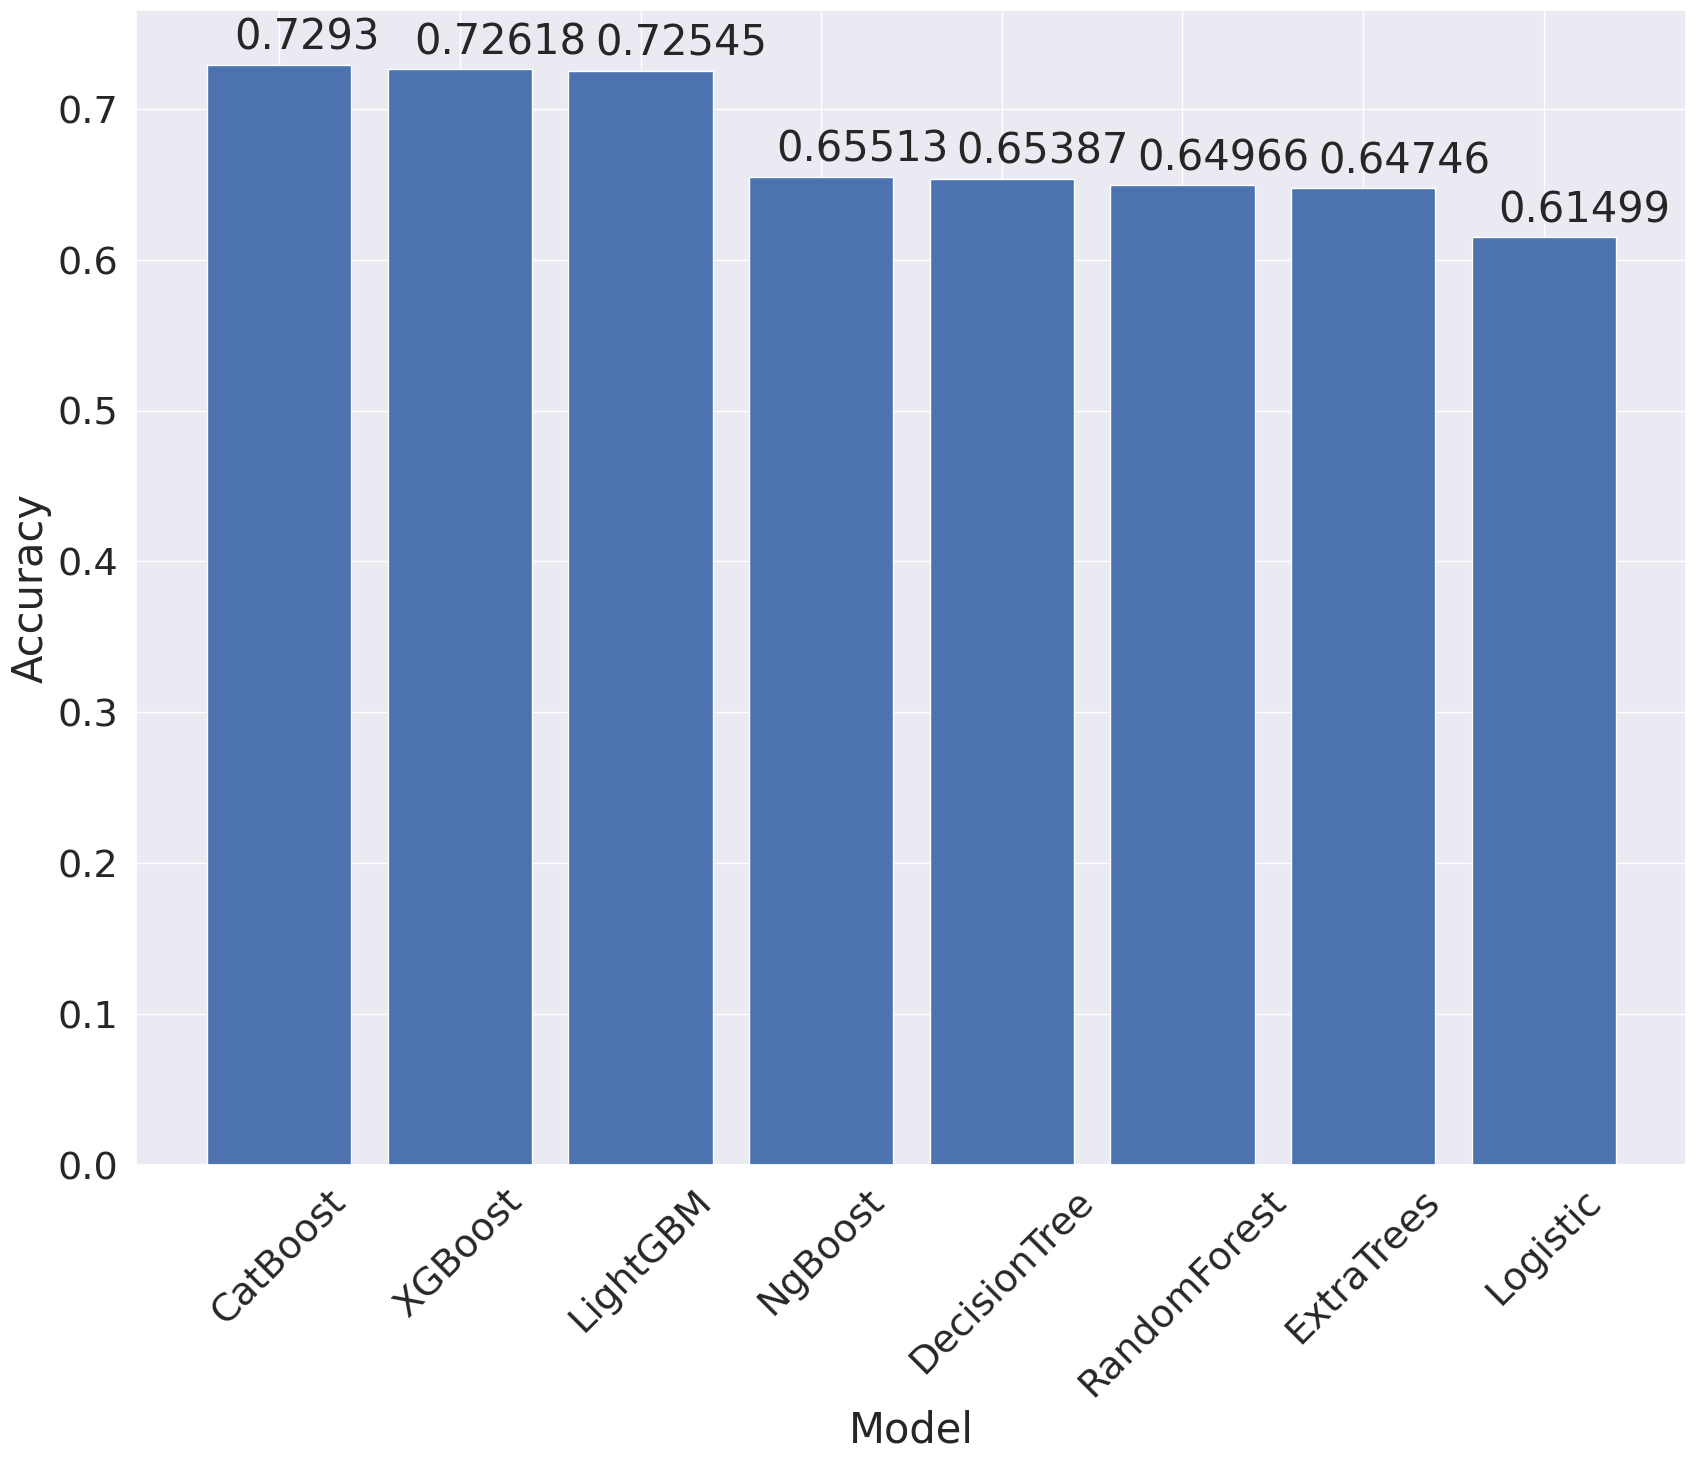

In [ ]:
model_scores = pd.DataFrame({ 'Model': [name for name, _ in models], 'Accuracy': scores })
model_scores.sort_values(by='Accuracy',ascending=False,inplace=True)
plot_metric(model_scores, score='Accuracy')

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrices = {}
# 각 모델에 대한 전퓨전 매트릭스 상성
for name, model in models:
    # 모델의 예측값 얻기
    y_pred = model.predict(X_test)
    # 컨퓨전 매트릭스 생성
    cm = confusion_matrix(y_test, y_pred)
    # 딕셔너리에 저장
    confusion_matrices[name] = cm

# 컨퓨전 매트릭스 출력
for name, cm in confusion_matrices. items():
    print(f"Confusion Matrix for {name}")
    print (cm)
    print()

Confusion Matrix for DecisionTree
[[61332 19085]
 [19328 11232]]

Confusion Matrix for RandomForest
[[60349 20068]
 [18812 11748]]

Confusion Matrix for ExtraTrees
[[63079 17338]
 [21786  8774]]

Confusion Matrix for XGBoost
[[76967  3450]
 [26938  3622]]

Confusion Matrix for LightGBM
[[77293  3124]
 [27345  3215]]

Confusion Matrix for CatBoost
[[77864  2553]
 [27489  3071]]

Confusion Matrix for NgBoost
[[61322 19095]
 [19178 11382]]

Confusion Matrix for Logistic
[[54898 25519]
 [17208 13352]]



In [ ]:
from sklearn.metrics import classification_report
for name, model in models:
    print(name)
    print(classification_report(y_test, model.predict(X_test)))
    print('----------------------------------------------------------------------------')

DecisionTree
              precision    recall  f1-score   support

           0       0.76      0.76      0.76     80417
           1       0.37      0.37      0.37     30560

    accuracy                           0.65    110977
   macro avg       0.57      0.57      0.57    110977
weighted avg       0.65      0.65      0.65    110977

----------------------------------------------------------------------------
RandomForest
              precision    recall  f1-score   support

           0       0.76      0.75      0.76     80417
           1       0.37      0.38      0.38     30560

    accuracy                           0.65    110977
   macro avg       0.57      0.57      0.57    110977
weighted avg       0.65      0.65      0.65    110977

----------------------------------------------------------------------------
ExtraTrees
              precision    recall  f1-score   support

           0       0.74      0.78      0.76     80417
           1       0.34      0.29      0.31   

In [ ]:
for name, model in models:
    print(name)
    print(classification_report(df_test['target'], model.predict(df_test[x_data])))
    print('----------------------------------------------------------------------------')

DecisionTree
              precision    recall  f1-score   support

           0       0.76      0.76      0.76     80765
           1       0.36      0.37      0.37     30212

    accuracy                           0.65    110977
   macro avg       0.56      0.56      0.56    110977
weighted avg       0.65      0.65      0.65    110977

----------------------------------------------------------------------------
RandomForest
              precision    recall  f1-score   support

           0       0.76      0.75      0.76     80765
           1       0.36      0.39      0.37     30212

    accuracy                           0.65    110977
   macro avg       0.56      0.57      0.56    110977
weighted avg       0.66      0.65      0.65    110977

----------------------------------------------------------------------------
ExtraTrees
              precision    recall  f1-score   support

           0       0.75      0.78      0.76     80765
           1       0.33      0.29      0.31   

                     feature  importance
27        home_ownership_OWN    0.197525
32  purpose_home_improvement    0.082953
10            inq_last_6mths    0.067105
37             purpose_other    0.064637
14               open_acc_6m    0.054305
34    purpose_major_purchase    0.049369
28       home_ownership_RENT    0.044067
22             grade_numeric    0.035740
15               open_act_il    0.034654
24   home_ownership_MORTGAGE    0.031948


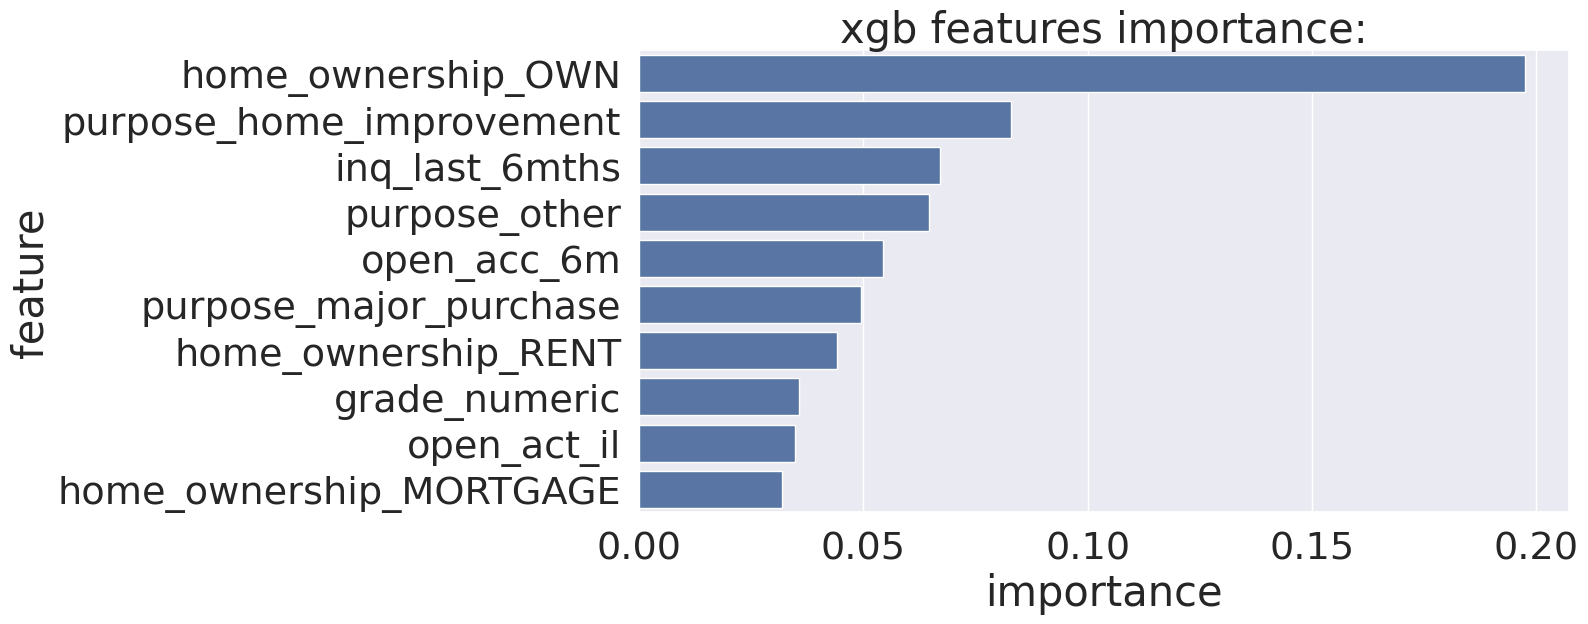

In [ ]:
feature_importances(X_train, xgboost, "xgb")

                 feature  importance
20          issue_d_year         252
15           open_act_il         195
3              loan_amnt         193
14           open_acc_6m         185
11              mort_acc         175
10        inq_last_6mths         152
2               int_rate         142
42       term_ 60 months         125
5   mo_sin_old_rev_tl_op         120
0         emp_length_int         120


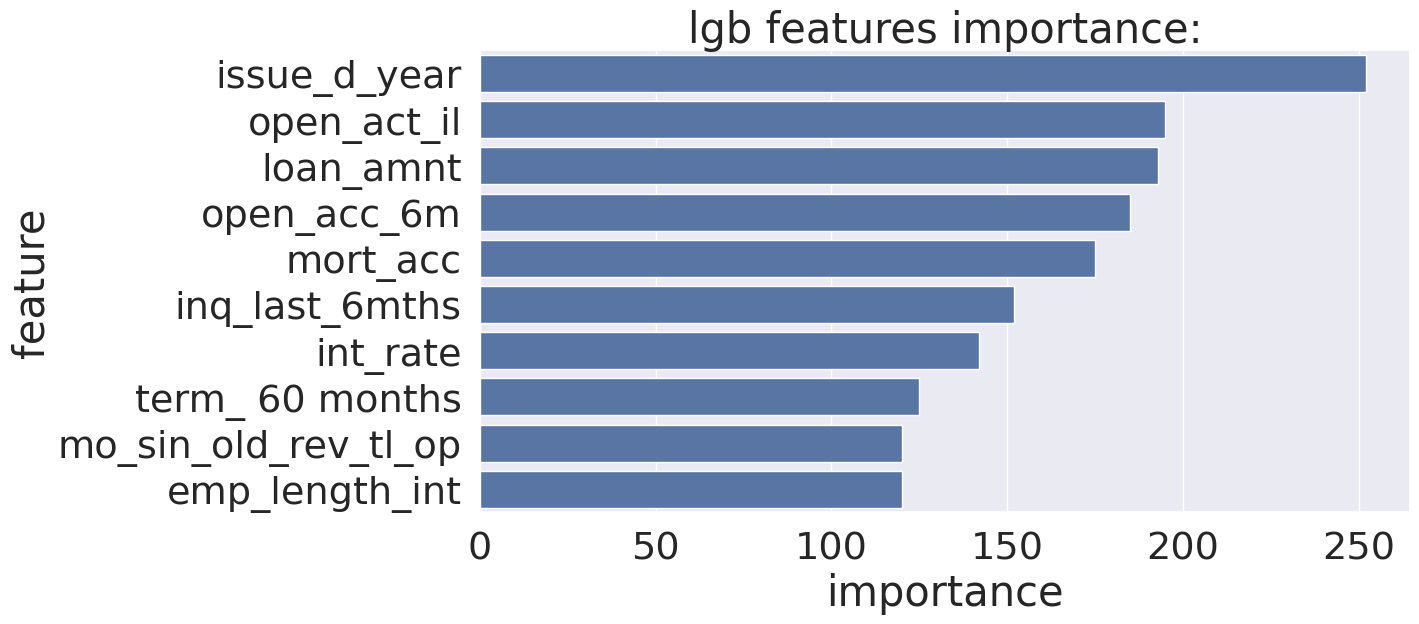

In [ ]:
feature_importances(X_train, lgb, 'lgb')

                    feature  importance
14              open_acc_6m   24.590214
15              open_act_il   22.719810
10           inq_last_6mths   18.252858
11                 mort_acc   13.784099
0            emp_length_int    5.752306
24  home_ownership_MORTGAGE    4.126603
13                 open_acc    3.997587
28      home_ownership_RENT    3.601627
27       home_ownership_OWN    2.299771
22            grade_numeric    0.233403


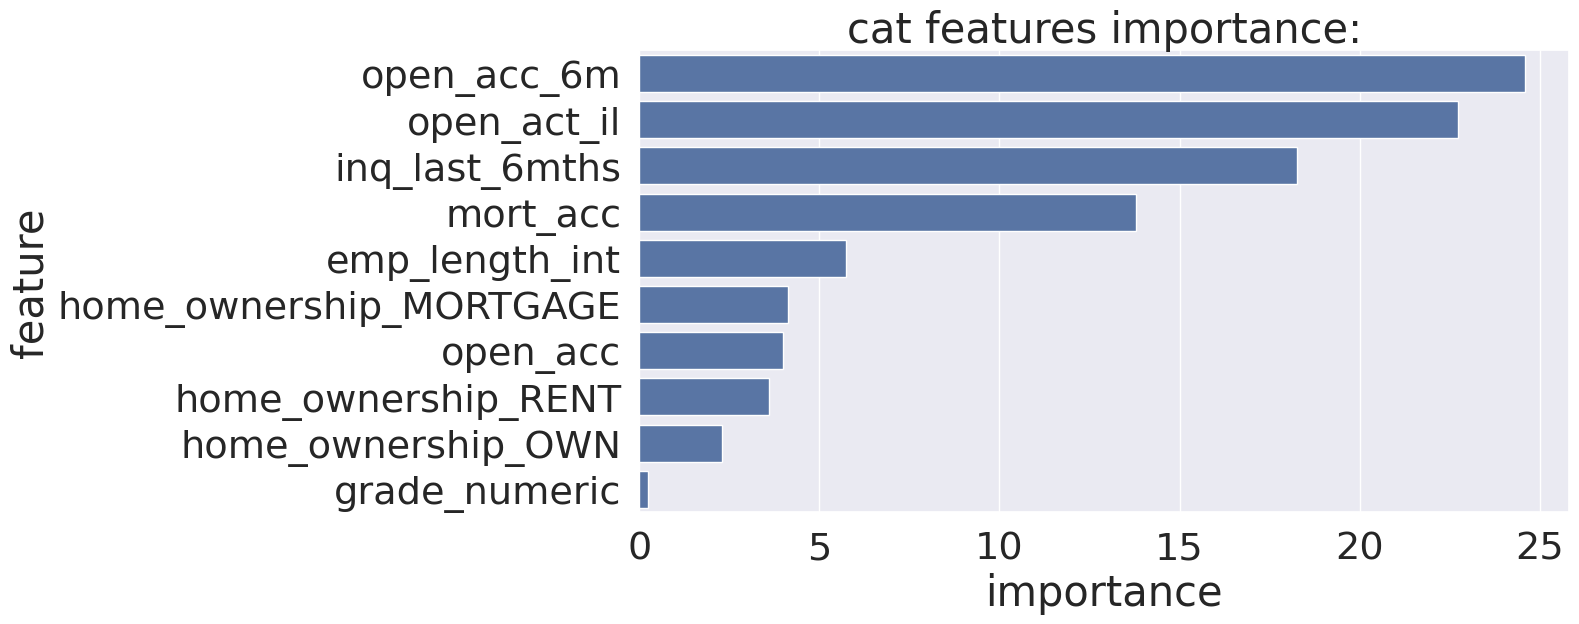

In [ ]:
feature_importances(X_train, cat, 'cat')

## 수익률 계산
1. 우수작 사례 - 개별로 계산
2. 현준님 계산 - 모두 평균으로 계산 -> 이거부터 진행
3. 비교

여기서 threshold 적용X 그냥 기본값만 생각해서 비교.

우수작부터(earning rate부터진행)

In [ ]:
# df_cal = pd.DataFrame()

# df_cal['target'] = ear

In [ ]:
# term = df_cal['term_ 60 months']
# temp = []

# for x in term:
#     if x == 1:
#         temp.append(60)
#     else:
#         temp.append(36)
# df_cal['term'] = temp

In [ ]:
# for name, model in models:
#     # 실제로 부도인데 못맞춘경우
#     A = df_cal[df_cal['target'] == 1 and df_cal[name] == 0]['installment']*(df_cal[df_cal['target'] == 1 and df_cal[name] == 0]['term']) - df_cal[df_cal['target'] == 1 and df_cal[name] == 0]['total_pymnt']
#     # 실제로 부도아닌데 부도라고 한 경우
#     B = df_cal[df_cal['target'] == 0 and df_cal[name] == 1]['total_pymnt'] - df_cal[df_cal['target'] == 0 and df_cal[name] == 1]['loan_amnt']

# print('총 손실',A.sum()+B.sum())

현준님 코드

In [ ]:
import sympy as sp

### earning_test를 돌리려면 이 아래만 돌려요

In [ ]:
# 계산을 위한 데이터셋으로 진행

cal = earning_test[['loan_amnt', 'int_rate', 'total_pymnt','grade_numeric']]
cal['loan_status'] = earning_test['target']

md =[('DecisionTree', decision_tree),
    ('RandomForest', random_forest),
    ('ExtraTrees', extra_trees),
    ('XGBoost', xgboost),
    ('LightGBM', lgb),
    ('CatBoost', cat),
    ('NgBoost', ngb),
    ('Logistic', model)]

In [ ]:
# standard로 scale
scaler = StandardScaler()
scaled_data = scaler.fit_transform(earning_test[processing])


# 새로운 DF에 스케일된 데이터를 저장
earning_test[processing] = scaled_data

In [ ]:
# add_rate지정
add_rate = 2.5

# for문으로 한번 변경해봄

for x in range(8):
    print(md[x][0])
    cal['predict'] = md[x][1].predict(earning_test[x_data])
    # 이자율 변환

    # 'total_pymnt'를 ('loan_amnt' * ('int_rate' + 100))로 나누어 'progress_rate' 열 생성
    cal['progress_rate'] = cal['total_pymnt'] / (cal['loan_amnt'] * (cal['int_rate'] + 100) / 100)

    # progress_rate가 1보다 큰 경우 1로 설정
    cal.loc[cal['progress_rate'] > 1, 'progress_rate'] = 1

    # 현재 은행의 실제 수익률

    cal_tp = cal['total_pymnt'].sum()

    # loan_amnt를 모두 더해서 cal_amnt 변수로
    cal_amnt = cal['loan_amnt'].sum()

    # cal_earning_rate 변수로 지정
    cal_earning_rate = cal_tp / cal_amnt

    # 결과 출력
    print("total_pymnt의 총 합 (cal_tp):", cal_tp)
    print("loan_amnt의 총 합 (cal_amnt):", cal_amnt)
    print("수익률 (cal_earning_rate):", cal_earning_rate)

    # 진행률은 부도가 난 대상의 평균으로 계산

    # loan_status가 1인 행들만 필터링
    filtered_cal = cal[cal['loan_status'] == 1]

    # progress_rate 열의 평균 계산
    progress_rate_mean = filtered_cal['progress_rate'].mean()

    # 결과 출력
    print("loan_status가 1인 행들의 progress_rate 열의 평균:", progress_rate_mean)

    # 평균 loan_amnt와 int_rate 계산

    int_rate_mean = cal['int_rate'].mean()
    rate_change = 1 + int_rate_mean/100
    loan_amnt_mean = cal['loan_amnt'].mean()


    print("int_rate 열의 평균:", int_rate_mean)
    print("loan_amnt 열의 평균:", loan_amnt_mean)

    # grade A,B를 올리기 위해 열 추가

    # 조건을 만족하는 행에 1을, 그렇지 않은 행에 0을 할당하는 add 열을 만듭니다.
    cal['gf'] = np.where((cal['grade_numeric'] >= 6), 1, 0)

    # 기존의 데이터 확인

    cal_1_prev = cal[(cal['loan_status'] == 0) & (cal['predict'] == 0)]
    cal_2_prev = cal[(cal['loan_status'] == 1) & (cal['predict'] == 0)]
    cal_3_prev = cal[(cal['loan_status'] == 0) & (cal['predict'] == 1)]
    cal_4_prev = cal[(cal['loan_status'] == 1) & (cal['predict'] == 1)]
    print("cal_1 (loan_status=0 & predict=0) shape:", cal_1_prev.shape)
    print("cal_2 (loan_status=1 & predict=0) shape:", cal_2_prev.shape)
    print("cal_3 (loan_status=0 & predict=1) shape:", cal_3_prev.shape)
    print("cal_4 (loan_status=1 & predict=1) shape:", cal_4_prev.shape)

    # 즉시 승인될 A,B의 개수 확인

    gf_value_counts1 = cal_3_prev['gf'].value_counts()
    gf_value_counts2 = cal_4_prev['gf'].value_counts()
    print(gf_value_counts1)
    print(gf_value_counts2)

    # A,B 승인

    cal_1 = cal[(cal['loan_status'] == 0) & (cal['predict'] == 0)]
    cal_2 = cal[(cal['loan_status'] == 1) & (cal['predict'] == 0)]
    cal_3 = cal[(cal['loan_status'] == 0) & (cal['predict'] == 1)]
    cal_4 = cal[(cal['loan_status'] == 1) & (cal['predict'] == 1)]

    # cal_1에 gf가 1인 행 추가
    cal_1 = pd.concat([cal_1, cal_3[cal_3['gf'] == 1]])

    # cal_3에서 gf가 1인 행 삭제
    cal_3 = cal_3[cal_3['gf'] != 1]

    # cal_2에 gf가 1인 행 추가
    cal_2 = pd.concat([cal_2, cal_4[cal_4['gf'] == 1]])

    # cal_4에서 gf가 1인 행 삭제
    cal_4 = cal_4[cal_4['gf'] != 1]

    # 결과 확인
    print("cal_1 (loan_status=0 & predict=0) shape:", cal_1.shape)
    print("cal_2 (loan_status=1 & predict=0) shape:", cal_2.shape)
    print("cal_3 (loan_status=0 & predict=1) shape:", cal_3.shape)
    print("cal_4 (loan_status=1 & predict=1) shape:", cal_4.shape)

    # 각 데이터셋의 크기 저장
    cal_1_size = cal_1.shape[0]
    cal_2_size = cal_2.shape[0]
    cal_3_size = cal_3.shape[0]
    cal_4_size = cal_4.shape[0]

    # 결과 출력
    print("cal_1 (loan_status=0 & predict=0) size:", cal_1_size)
    print("cal_2 (loan_status=1 & predict=0) size:", cal_2_size)
    print("cal_3 (loan_status=0 & predict=1) size:", cal_3_size)
    print("cal_4 (loan_status=1 & predict=1) size:", cal_4_size)
    print(cal_1_size+cal_2_size+cal_3_size+cal_4_size)

    # grade A를 모두 승인한 accuracy

    changed_accuracy = (cal_1_size+cal_4_size)/(cal_1_size+cal_2_size+cal_3_size+cal_4_size)
    print(changed_accuracy)

    # 현재의 부도율 -> 추가 이자율 x를 계산하는 데 쓰임

    deliq_rate = (cal_2_size+cal_4_size)/(cal_1_size+cal_2_size+cal_3_size+cal_4_size)
    print(deliq_rate)

    # 평균으로 계산한 수익률

    real_earning_rate = (cal_1_size*rate_change+cal_2_size*rate_change*progress_rate_mean)/(cal_1_size+cal_2_size)

    print(real_earning_rate)

    # 은행의 수익률을 올리기 위해 추가 이자 x%를 더 받고 더 많은 수익을 내보자
    # 먼저 x% 구하기부터
    # 제안을 수락하는 비율 accept_rate는 아래 공식과 무관함. 따라서 accept_rate는 50%로 가정하고 시작
    # 진행률은 현재 진행률이 88%인 점과 이미 reject된 사람들이라는 것을 감안하여 보수적으로 80%만 진행될 것으로 가정



    x = sp.symbols('x')
    accept_rate = 0.3
    expect_progress_rate = progress_rate_mean
    equation = real_earning_rate -(
                        (cal_1_size*rate_change+((cal_3_size+cal_4_size)*accept_rate*(1-deliq_rate))*(rate_change+x)
                        +((cal_2_size*rate_change+(cal_3_size+cal_4_size)*accept_rate*deliq_rate*(rate_change+x))*expect_progress_rate))
                        /(cal_1_size+cal_2_size+(cal_3_size+cal_4_size)*accept_rate)
                    )

    # 방정식의 근 찾기
    roots = sp.solve(equation, x)
    print("방정식의 근:", roots)

    # 이자율 조정

    cal_1['int_rate'] = (cal_1['int_rate'] / 100) + 1
    cal_2['int_rate'] = (cal_2['int_rate'] / 100) + 1
    cal_3['int_rate'] = (cal_3['int_rate'] / 100) + 1
    cal_4['int_rate'] = (cal_4['int_rate'] / 100) + 1

    # 갚은 금액

    cal_1_amnt = (cal_1['loan_amnt'] * cal_1['int_rate']).sum()
    cal_2_amnt = (cal_2['loan_amnt'] * cal_2['int_rate']).sum()
    cal_3_amnt = (cal_3['loan_amnt'] * cal_3['int_rate']).sum()
    cal_4_amnt = (cal_4['loan_amnt'] * cal_4['int_rate']).sum()

    print("cal_1_amnt:", cal_1_amnt)
    print("cal_2_amnt:", cal_2_amnt)
    print("cal_3_amnt:", cal_3_amnt)
    print("cal_4_amnt:", cal_4_amnt)

    # 대출 금액

    cal_1_loan = cal_1['loan_amnt'].sum()
    cal_2_loan = cal_2['loan_amnt'].sum()
    cal_3_loan = cal_3['loan_amnt'].sum()
    cal_4_loan = cal_4['loan_amnt'].sum()

    print("cal_1_loan:", cal_1_loan)
    print("cal_2_loan:", cal_2_loan)
    print("cal_3_loan:", cal_3_loan)
    print("cal_4_loan:", cal_4_loan)

    # 진행률 반영

    cal_1_progress = (cal_1['loan_amnt'] * cal_1['int_rate'] * cal_1['progress_rate']).sum()
    cal_2_progress = (cal_2['loan_amnt'] * cal_2['int_rate'] * cal_2['progress_rate']).sum()
    cal_3_progress = (cal_3['loan_amnt'] * cal_3['int_rate'] * cal_3['progress_rate']).sum()
    cal_4_progress = (cal_4['loan_amnt'] * cal_4['int_rate'] * cal_4['progress_rate']).sum()

    # 결과 출력
    print("cal_1_progress:", cal_1_progress)
    print("cal_2_progress:", cal_2_progress)
    print("cal_3_progress:", cal_3_progress)
    print("cal_4_progress:", cal_4_progress)

    # 30%가 승인했다고 가정

    cal_3_sample = cal_3.sample(frac=0.3, random_state=42)
    cal_4_sample = cal_4.sample(frac=0.3, random_state=42)

    # 현재 부도율 20% 반영해서 랜덤하게 8:2로 나눔

    cal_3_sample_80 = cal_3_sample.sample(frac=0.8, random_state=42)
    cal_3_sample_20 = cal_3_sample.drop(cal_3_sample_80.index)
    cal_4_sample_80 = cal_4_sample.sample(frac=0.8, random_state=42)
    cal_4_sample_20 = cal_4_sample.drop(cal_4_sample_80.index)

    cal_3_sample_loan = cal_3_sample['loan_amnt'].sum()
    cal_4_sample_loan = cal_4_sample['loan_amnt'].sum()
    print(cal_3_sample_loan)
    print(cal_4_sample_loan)


    # 추가이자율 반영 이자율 조정

    cal_3_sample_80['int_rate'] = cal_3_sample_80['int_rate'] + add_rate
    cal_4_sample_80['int_rate'] = cal_4_sample_80['int_rate'] + add_rate
    cal_3_sample_20['int_rate'] = cal_3_sample_20['int_rate'] + add_rate
    cal_4_sample_20['int_rate'] = cal_4_sample_20['int_rate'] + add_rate


    # 80%는 다 갚을거니까 거기에 추가이자율만 더해서 계산

    cal_3_sample_80_add = (cal_3_sample_80['loan_amnt'] * cal_3_sample_80['int_rate']).sum()
    cal_4_sample_80_add = (cal_4_sample_80['loan_amnt'] * cal_4_sample_80['int_rate']).sum()
    print(cal_3_sample_80_add)
    print(cal_4_sample_80_add)

    # 20%는 부도를 낼거니까 추가이자율을 더해주고 진행률까지 곱해서 계산

    cal_3_sample_20_progress = (cal_3_sample_20['loan_amnt'] * cal_3_sample_20['int_rate'] * cal_3_sample_20['progress_rate']).sum()
    cal_4_sample_20_progress = (cal_4_sample_20['loan_amnt'] * cal_4_sample_20['int_rate'] * cal_4_sample_20['progress_rate']).sum()
    print(cal_3_sample_20_progress)
    print(cal_4_sample_20_progress)

    # 우리 모델의 현재 수익률

    present_model_earning_rate = (cal_1_amnt+cal_2_progress)/(cal_1_loan+cal_2_loan)
    print(present_model_earning_rate)

    # 풀을 늘린 수익률

    additional_model_earning_rate = (cal_1_amnt+cal_3_sample_80_add+cal_4_sample_80_add+cal_2_progress+cal_3_sample_20_progress+cal_4_sample_20_progress)/(cal_1_loan+cal_2_loan+cal_3_sample_loan+cal_4_sample_loan)
    print(additional_model_earning_rate)
    print('------------------------------------------------------------------------------------------------------------]')

DecisionTree
total_pymnt의 총 합 (cal_tp): 3195695600.0
loan_amnt의 총 합 (cal_amnt): 3068462800.0
수익률 (cal_earning_rate): 1.0414647
loan_status가 1인 행들의 progress_rate 열의 평균: 0.48712593
int_rate 열의 평균: 13.118572
loan_amnt 열의 평균: 14333.119
cal_1 (loan_status=0 & predict=0) shape: (98036, 8)
cal_2 (loan_status=1 & predict=0) shape: (19915, 8)
cal_3 (loan_status=0 & predict=1) shape: (74433, 8)
cal_4 (loan_status=1 & predict=1) shape: (21698, 8)
gf
0    39376
1    35057
Name: count, dtype: int64
gf
0    17802
1     3896
Name: count, dtype: int64
cal_1 (loan_status=0 & predict=0) shape: (133093, 8)
cal_2 (loan_status=1 & predict=0) shape: (23811, 8)
cal_3 (loan_status=0 & predict=1) shape: (39376, 8)
cal_4 (loan_status=1 & predict=1) shape: (17802, 8)
cal_1 (loan_status=0 & predict=0) size: 133093
cal_2 (loan_status=1 & predict=0) size: 23811
cal_3 (loan_status=0 & predict=1) size: 39376
cal_4 (loan_status=1 & predict=1) size: 17802
214082
0.7048467409684139
0.19437878943582365
1.043144051826602


### test셋만 돌리고 싶으면 이 아래만 돌려요

In [ ]:
cal2 = df2[['loan_amnt', 'int_rate', 'total_pymnt','grade_numeric']]
cal2['loan_status'] = df2['target']

md =[('DecisionTree', decision_tree),
    ('RandomForest', random_forest),
    ('ExtraTrees', extra_trees),
    ('XGBoost', xgboost),
    ('LightGBM', lgb),
    ('CatBoost', cat),
    ('NgBoost', ngb),
    ('Logistic', model)]


In [ ]:
# standard로 scale
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df2[processing])


# 새로운 DF에 스케일된 데이터를 저장
df2[processing] = scaled_data

In [ ]:
# add_rate지정
add_rate = 2.5

# for문으로 한번 변경해봄

for x in range(8):
    print(md[x][0])
    cal2['predict'] = md[x][1].predict(df2[x_data])
    # 이자율 변환

    # 'total_pymnt'를 ('loan_amnt' * ('int_rate' + 100))로 나누어 'progress_rate' 열 생성
    cal2['progress_rate'] = cal2['total_pymnt'] / (cal2['loan_amnt'] * (cal2['int_rate'] + 100) / 100)

    # progress_rate가 1보다 큰 경우 1로 설정
    cal2.loc[cal2['progress_rate'] > 1, 'progress_rate'] = 1

    # 현재 은행의 실제 수익률

    cal2_tp = cal2['total_pymnt'].sum()

    # loan_amnt를 모두 더해서 cal2_amnt 변수로
    cal2_amnt = cal2['loan_amnt'].sum()

    # cal2_earning_rate 변수로 지정
    cal2_earning_rate = cal2_tp / cal2_amnt

    # 결과 출력
    print("total_pymnt의 총 합 (cal2_tp):", cal2_tp)
    print("loan_amnt의 총 합 (cal2_amnt):", cal2_amnt)
    print("수익률 (cal2_earning_rate):", cal2_earning_rate)

    # 진행률은 부도가 난 대상의 평균으로 계산

    # loan_status가 1인 행들만 필터링
    filtered_cal2 = cal2[cal2['loan_status'] == 1]

    # progress_rate 열의 평균 계산
    progress_rate_mean = filtered_cal2['progress_rate'].mean()

    # 결과 출력
    print("loan_status가 1인 행들의 progress_rate 열의 평균:", progress_rate_mean)

    # 평균 loan_amnt와 int_rate 계산

    int_rate_mean = cal2['int_rate'].mean()
    rate_change = 1 + int_rate_mean/100
    loan_amnt_mean = cal2['loan_amnt'].mean()


    print("int_rate 열의 평균:", int_rate_mean)
    print("loan_amnt 열의 평균:", loan_amnt_mean)

    # grade A,B를 올리기 위해 열 추가

    # 조건을 만족하는 행에 1을, 그렇지 않은 행에 0을 할당하는 add 열을 만듭니다.
    cal2['gf'] = np.where((cal2['grade_numeric'] >= 6), 1, 0)

    # 기존의 데이터 확인

    cal2_1_prev = cal2[(cal2['loan_status'] == 0) & (cal2['predict'] == 0)]
    cal2_2_prev = cal2[(cal2['loan_status'] == 1) & (cal2['predict'] == 0)]
    cal2_3_prev = cal2[(cal2['loan_status'] == 0) & (cal2['predict'] == 1)]
    cal2_4_prev = cal2[(cal2['loan_status'] == 1) & (cal2['predict'] == 1)]
    print("cal2_1 (loan_status=0 & predict=0) shape:", cal2_1_prev.shape)
    print("cal2_2 (loan_status=1 & predict=0) shape:", cal2_2_prev.shape)
    print("cal2_3 (loan_status=0 & predict=1) shape:", cal2_3_prev.shape)
    print("cal2_4 (loan_status=1 & predict=1) shape:", cal2_4_prev.shape)

    # 즉시 승인될 A,B의 개수 확인

    gf_value_counts1 = cal2_3_prev['gf'].value_counts()
    gf_value_counts2 = cal2_4_prev['gf'].value_counts()
    print(gf_value_counts1)
    print(gf_value_counts2)

    # A,B 승인

    cal2_1 = cal2[(cal2['loan_status'] == 0) & (cal2['predict'] == 0)]
    cal2_2 = cal2[(cal2['loan_status'] == 1) & (cal2['predict'] == 0)]
    cal2_3 = cal2[(cal2['loan_status'] == 0) & (cal2['predict'] == 1)]
    cal2_4 = cal2[(cal2['loan_status'] == 1) & (cal2['predict'] == 1)]

    # cal2_1에 gf가 1인 행 추가
    cal2_1 = pd.concat([cal2_1, cal2_3[cal2_3['gf'] == 1]])

    # cal2_3에서 gf가 1인 행 삭제
    cal2_3 = cal2_3[cal2_3['gf'] != 1]

    # cal2_2에 gf가 1인 행 추가
    cal2_2 = pd.concat([cal2_2, cal2_4[cal2_4['gf'] == 1]])

    # cal2_4에서 gf가 1인 행 삭제
    cal2_4 = cal2_4[cal2_4['gf'] != 1]

    # 결과 확인
    print("cal2_1 (loan_status=0 & predict=0) shape:", cal2_1.shape)
    print("cal2_2 (loan_status=1 & predict=0) shape:", cal2_2.shape)
    print("cal2_3 (loan_status=0 & predict=1) shape:", cal2_3.shape)
    print("cal2_4 (loan_status=1 & predict=1) shape:", cal2_4.shape)

    # 각 데이터셋의 크기 저장
    cal2_1_size = cal2_1.shape[0]
    cal2_2_size = cal2_2.shape[0]
    cal2_3_size = cal2_3.shape[0]
    cal2_4_size = cal2_4.shape[0]

    # 결과 출력
    print("cal2_1 (loan_status=0 & predict=0) size:", cal2_1_size)
    print("cal2_2 (loan_status=1 & predict=0) size:", cal2_2_size)
    print("cal2_3 (loan_status=0 & predict=1) size:", cal2_3_size)
    print("cal2_4 (loan_status=1 & predict=1) size:", cal2_4_size)
    print(cal2_1_size+cal2_2_size+cal2_3_size+cal2_4_size)

    # grade A를 모두 승인한 accuracy

    changed_accuracy = (cal2_1_size+cal2_4_size)/(cal2_1_size+cal2_2_size+cal2_3_size+cal2_4_size)
    print(changed_accuracy)

    # 현재의 부도율 -> 추가 이자율 x를 계산하는 데 쓰임

    deliq_rate = (cal2_2_size+cal2_4_size)/(cal2_1_size+cal2_2_size+cal2_3_size+cal2_4_size)
    print(deliq_rate)

    # 평균으로 계산한 수익률

    real_earning_rate = (cal2_1_size*rate_change+cal2_2_size*rate_change*progress_rate_mean)/(cal2_1_size+cal2_2_size)

    print(real_earning_rate)

    # 은행의 수익률을 올리기 위해 추가 이자 x%를 더 받고 더 많은 수익을 내보자
    # 먼저 x% 구하기부터
    # 제안을 수락하는 비율 accept_rate는 아래 공식과 무관함. 따라서 accept_rate는 50%로 가정하고 시작
    # 진행률은 현재 진행률이 88%인 점과 이미 reject된 사람들이라는 것을 감안하여 보수적으로 80%만 진행될 것으로 가정



    x = sp.symbols('x')
    accept_rate = 0.3
    expect_progress_rate = progress_rate_mean
    equation = real_earning_rate -(
                        (cal2_1_size*rate_change+((cal2_3_size+cal2_4_size)*accept_rate*(1-deliq_rate))*(rate_change+x)
                        +((cal2_2_size*rate_change+(cal2_3_size+cal2_4_size)*accept_rate*deliq_rate*(rate_change+x))*expect_progress_rate))
                        /(cal2_1_size+cal2_2_size+(cal2_3_size+cal2_4_size)*accept_rate)
                    )

    # 방정식의 근 찾기
    roots = sp.solve(equation, x)
    print("방정식의 근:", roots)

    # 이자율 조정

    cal2_1['int_rate'] = (cal2_1['int_rate'] / 100) + 1
    cal2_2['int_rate'] = (cal2_2['int_rate'] / 100) + 1
    cal2_3['int_rate'] = (cal2_3['int_rate'] / 100) + 1
    cal2_4['int_rate'] = (cal2_4['int_rate'] / 100) + 1

    # 갚은 금액

    cal2_1_amnt = (cal2_1['loan_amnt'] * cal2_1['int_rate']).sum()
    cal2_2_amnt = (cal2_2['loan_amnt'] * cal2_2['int_rate']).sum()
    cal2_3_amnt = (cal2_3['loan_amnt'] * cal2_3['int_rate']).sum()
    cal2_4_amnt = (cal2_4['loan_amnt'] * cal2_4['int_rate']).sum()

    print("cal2_1_amnt:", cal2_1_amnt)
    print("cal2_2_amnt:", cal2_2_amnt)
    print("cal2_3_amnt:", cal2_3_amnt)
    print("cal2_4_amnt:", cal2_4_amnt)

    # 대출 금액

    cal2_1_loan = cal2_1['loan_amnt'].sum()
    cal2_2_loan = cal2_2['loan_amnt'].sum()
    cal2_3_loan = cal2_3['loan_amnt'].sum()
    cal2_4_loan = cal2_4['loan_amnt'].sum()

    print("cal2_1_loan:", cal2_1_loan)
    print("cal2_2_loan:", cal2_2_loan)
    print("cal2_3_loan:", cal2_3_loan)
    print("cal2_4_loan:", cal2_4_loan)

    # 진행률 반영

    cal2_1_progress = (cal2_1['loan_amnt'] * cal2_1['int_rate'] * cal2_1['progress_rate']).sum()
    cal2_2_progress = (cal2_2['loan_amnt'] * cal2_2['int_rate'] * cal2_2['progress_rate']).sum()
    cal2_3_progress = (cal2_3['loan_amnt'] * cal2_3['int_rate'] * cal2_3['progress_rate']).sum()
    cal2_4_progress = (cal2_4['loan_amnt'] * cal2_4['int_rate'] * cal2_4['progress_rate']).sum()

    # 결과 출력
    print("cal2_1_progress:", cal2_1_progress)
    print("cal2_2_progress:", cal2_2_progress)
    print("cal2_3_progress:", cal2_3_progress)
    print("cal2_4_progress:", cal2_4_progress)

    # 30%가 승인했다고 가정

    cal2_3_sample = cal2_3.sample(frac=0.3, random_state=42)
    cal2_4_sample = cal2_4.sample(frac=0.3, random_state=42)

    # 현재 부도율 20% 반영해서 랜덤하게 8:2로 나눔

    cal2_3_sample_80 = cal2_3_sample.sample(frac=0.8, random_state=42)
    cal2_3_sample_20 = cal2_3_sample.drop(cal2_3_sample_80.index)
    cal2_4_sample_80 = cal2_4_sample.sample(frac=0.8, random_state=42)
    cal2_4_sample_20 = cal2_4_sample.drop(cal2_4_sample_80.index)

    cal2_3_sample_loan = cal2_3_sample['loan_amnt'].sum()
    cal2_4_sample_loan = cal2_4_sample['loan_amnt'].sum()
    print(cal2_3_sample_loan)
    print(cal2_4_sample_loan)


    # 추가이자율 반영 이자율 조정

    cal2_3_sample_80['int_rate'] = cal2_3_sample_80['int_rate'] + add_rate
    cal2_4_sample_80['int_rate'] = cal2_4_sample_80['int_rate'] + add_rate
    cal2_3_sample_20['int_rate'] = cal2_3_sample_20['int_rate'] + add_rate
    cal2_4_sample_20['int_rate'] = cal2_4_sample_20['int_rate'] + add_rate


    # 80%는 다 갚을거니까 거기에 추가이자율만 더해서 계산

    cal2_3_sample_80_add = (cal2_3_sample_80['loan_amnt'] * cal2_3_sample_80['int_rate']).sum()
    cal2_4_sample_80_add = (cal2_4_sample_80['loan_amnt'] * cal2_4_sample_80['int_rate']).sum()
    print(cal2_3_sample_80_add)
    print(cal2_4_sample_80_add)

    # 20%는 부도를 낼거니까 추가이자율을 더해주고 진행률까지 곱해서 계산

    cal2_3_sample_20_progress = (cal2_3_sample_20['loan_amnt'] * cal2_3_sample_20['int_rate'] * cal2_3_sample_20['progress_rate']).sum()
    cal2_4_sample_20_progress = (cal2_4_sample_20['loan_amnt'] * cal2_4_sample_20['int_rate'] * cal2_4_sample_20['progress_rate']).sum()
    print(cal2_3_sample_20_progress)
    print(cal2_4_sample_20_progress)

    # 우리 모델의 현재 수익률

    present_model_earning_rate = (cal2_1_amnt+cal2_2_progress)/(cal2_1_loan+cal2_2_loan)
    print(present_model_earning_rate)

    # 풀을 늘린 수익률

    additional_model_earning_rate = (cal2_1_amnt+cal2_3_sample_80_add+cal2_4_sample_80_add+cal2_2_progress+cal2_3_sample_20_progress+cal2_4_sample_20_progress)/(cal2_1_loan+cal2_2_loan+cal2_3_sample_loan+cal2_4_sample_loan)
    print(additional_model_earning_rate)
    print('------------------------------------------------------------------------------------------------------------]')

DecisionTree
total_pymnt의 총 합 (cal2_tp): 10713848000.0
loan_amnt의 총 합 (cal2_amnt): 10285950000.0
수익률 (cal2_earning_rate): 1.0416002
loan_status가 1인 행들의 progress_rate 열의 평균: 0.4891642
int_rate 열의 평균: 13.131456
loan_amnt 열의 평균: 14409.806
cal2_1 (loan_status=0 & predict=0) shape: (324575, 8)
cal2_2 (loan_status=1 & predict=0) shape: (66847, 8)
cal2_3 (loan_status=0 & predict=1) shape: (249808, 8)
cal2_4 (loan_status=1 & predict=1) shape: (72586, 8)
gf
0    132882
1    116926
Name: count, dtype: int64
gf
0    59400
1    13186
Name: count, dtype: int64
cal2_1 (loan_status=0 & predict=0) shape: (441501, 8)
cal2_2 (loan_status=1 & predict=0) shape: (80033, 8)
cal2_3 (loan_status=0 & predict=1) shape: (132882, 8)
cal2_4 (loan_status=1 & predict=1) shape: (59400, 8)
cal2_1 (loan_status=0 & predict=0) size: 441501
cal2_2 (loan_status=1 & predict=0) size: 80033
cal2_3 (loan_status=0 & predict=1) size: 132882
cal2_4 (loan_status=1 & predict=1) size: 59400
713816
0.7017228529480987
0.19533465206719